In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
resultsdir = '/users/genomics/xoel/codebases/co_new/results/'
os.makedirs(resultsdir, exist_ok=True)
os.chdir(resultsdir)

In [4]:
selected_samples = ['RGCmaturation',
                    'NeuralPCW16',
                    'NeuralPCW20',
                    'NeuralPCW21',
                    'NeuralPCW24',
                    'Gliogenesis']

In [5]:
datadir = '/users/genomics/xoel/codebases/co_new/data/'
dirlist = {item: datadir+item+'/' for item in sorted(os.listdir(datadir)) if os.path.isdir(os.path.join(datadir, item)) if item[0]!='.' if item in selected_samples}
dirlist

{'Gliogenesis': '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/',
 'NeuralPCW16': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW16/',
 'NeuralPCW20': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW20/',
 'NeuralPCW21': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW21/',
 'NeuralPCW24': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW24/',
 'RGCmaturation': '/users/genomics/xoel/codebases/co_new/data/RGCmaturation/'}

In [6]:
n_cores = int(os.getenv('SLURM_JOB_CPUS_PER_NODE') or 16)
n_cores

96

# Load genes of interest

## Gene lists

### Diseases

In [7]:
diseases = pd.read_csv('/users/genomics/xoel/codebases/cortical_disorders2/data/gene_disorder_associations.intersectionExpData.csv', index_col=0)
diseases = diseases[diseases.sum(1).astype(bool)]

disease_genes = diseases.index.unique().tolist()

### TFs

In [8]:
tfs = pd.read_csv('/users/genomics/xoel/codebases/cortical_disorders2/raw/HumanTFs/DatabaseExtract_v_1.01.csv', index_col=0)
tfs = tfs[tfs['Is TF?']=='Yes']
tf_genes = tfs['HGNC symbol'].str.strip().unique().tolist()

______________________

In [9]:
glists = {'Diseases': disease_genes,
          'TFs': tf_genes}

### Regulons

#### Disease

In [10]:
disreg = pd.read_csv('/users/genomics/xoel/codebases/cortical_disorders2/results/RCT_diseases/cisTarget_regulons.csv')

disreg_genes = np.unique(disreg[['Core', 'Target']].to_numpy().flatten()).tolist()
disreg_cores = disreg['Core'].unique().tolist()
disreg_targets = disreg['Target'].unique().tolist()

glists['Disease regulon'] = disreg_genes
glists['Disease core'] = disreg_cores
glists['Disease target'] = disreg_targets

In [11]:
disset_cores = {k+' core': v['Core'].unique().tolist() for k,v in disreg.groupby('geneSet')}
disset_targets = {k+' target': v['Target'].unique().tolist() for k,v in disreg.groupby('geneSet')}

glists.update(disset_cores)
glists.update(disset_targets)

#### Peaks

In [12]:
peakreg = pd.read_csv('/users/genomics/xoel/codebases/cortical_disorders2/results/RCT_peaks/cisTarget_regulons.csv')

peakreg_genes = np.unique(peakreg[['Core', 'Target']].to_numpy().flatten())
peakreg_cores = peakreg['Core'].unique()
peakreg_targets = peakreg['Target'].unique()


glists['Peak regulon'] = peakreg_genes
glists['Peak core'] = peakreg_cores
glists['Peak target'] = peakreg_targets

In [13]:
peakset_cores = {k+' core': v['Core'].unique().tolist() for k,v in peakreg.groupby('geneSet')}
peakset_targets = {k+' target': v['Target'].unique().tolist() for k,v in peakreg.groupby('geneSet')}

glists.update(peakset_cores)
glists.update(peakset_targets)

In [14]:
regulon_genes = sorted(list(set(disreg_genes).union(set(peakreg_genes))))
regulon_cores = sorted(list(set(disreg_cores).union(set(peakreg_cores))))
regulon_targets = sorted(list(set(disreg_targets).union(set(peakreg_targets))))

glists['Regulon gene'] = regulon_genes
glists['Regulon core'] = regulon_cores
glists['Regulon target'] = regulon_targets

In [15]:
g_subsets = {
    'Cores': np.unique(glists['Regulon core']),
    'Cores+Dis': np.unique(list(glists['Regulon core'])+list(glists['Diseases'])),
    'DiseaseRisk': np.unique(glists['Diseases']),
    'PeakCores+DisReg': np.unique(list(glists['Regulon core'])+list(glists['Disease regulon']))
}

# Links filtering

In [16]:
links_folders = {k: f+'cluster_GRN/' for k,f in dirlist.items()}
links_folders

{'Gliogenesis': '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/cluster_GRN/',
 'NeuralPCW16': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW16/cluster_GRN/',
 'NeuralPCW20': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW20/cluster_GRN/',
 'NeuralPCW21': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW21/cluster_GRN/',
 'NeuralPCW24': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW24/cluster_GRN/',
 'RGCmaturation': '/users/genomics/xoel/codebases/co_new/data/RGCmaturation/cluster_GRN/'}

In [17]:
grn_links = []

for sample, link_folder in tqdm(links_folders.items()):
    # print(sample)
    link_files = os.listdir(link_folder)
    clusters = set([f.split('.')[0] for f in link_files if f[0] != '.'])
    clusters

    grns_df = []

    for cl in tqdm(clusters, colour='yellow'):
        
        raw_grn = pd.read_csv(
            [os.path.join(link_folder, l) for l in link_files if cl in l and 'raw_GRN' in l][0], 
            index_col=[0]).sort_values(by='p', ascending=True)
        
        filt_grn = pd.read_csv(
            [os.path.join(link_folder, l) for l in link_files if cl in l and 'filtered_GRN' in l][0], 
            index_col=[0]).sort_values(by='p', ascending=True)

        raw_grn['cell.type'] = cl
        raw_grn['kept'] = raw_grn.index.isin(filt_grn.index)

        grns_df.append(raw_grn)
#         # print(raw_grn.head())

    grns_df = pd.concat(grns_df, ignore_index=True)
    grns_df['Sample'] = sample

    grn_links.append(grns_df)

grn_links = pd.concat(grn_links, ignore_index=True)
print(grn_links.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(6334930, 9)


In [ ]:
grn_links = grn_links[~(grn_links['coef_mean'] == 0 & grn_links['p'].isna() & ~grn_links['kept'])]

In [ ]:
grn_links.to_csv(resultsdir+'LinkFiltering.txt', index=False, header=True, sep='\t')

In [ ]:
max_excel_rows = 1048576

with pd.ExcelWriter('LinkFiltering.xlsx') as writer:
    for sample, sdf in grn_links.groupby('Sample'):
        print(f'Writing excel sheet: {sample}')
        if sdf.shape[0] < max_excel_rows:
            sdf.to_excel(writer, sheet_name=sample, index=False, header=True)

        else:
            print('Dividing...')
            sdf.iloc[:max_excel_rows,:].to_excel(writer, sheet_name=sample+'_1', index=False, header=True)
            sdf.iloc[max_excel_rows:,:].to_excel(writer, sheet_name=sample+'_2', index=False, header=True)


# Merged scores

In [ ]:
import celloracle as co

In [ ]:
dirlist.items()

In [ ]:
links_files = {k: v+[f for f in os.listdir(v) if 'celloracle.links' in f and not 'Perturbation' in f][0] for k, v in dirlist.items()}
links_files

In [ ]:
scores_df = []
for tag, fname in links_files.items():
    print(tag)
    scores = co.load_hdf5(fname).merged_score.reset_index().rename(
        columns={'name':'Gene', 'cluster': 'cell.type'})
    scores['Sample'] = tag
    scores_df.append(scores)
scores_df = pd.concat(scores_df, axis=0, ignore_index=True)
scores_df['is.source'] = scores_df['Gene'].isin(grn_links['source'].unique())

In [ ]:
scores_df.head()

In [ ]:
scores_df.to_csv(resultsdir+'NetworkScores.txt', index=False, header=True, sep='\t')
scores_df.to_excel(resultsdir+'NetworkScores.xlsx', index=False, header=True)

# Perturbation per gene

### Funs

In [16]:
import numpy as np

In [17]:
from tqdm.contrib.concurrent import process_map  # or thread_map

In [18]:
def _summarize_pert(df):
    max_sim = max(df['Sim.step'])
    n_replicates = len(df['Replicate'].unique())
    n_cells = len(df['Cell.ID'].unique())
    
    seriess = []
    for (ct, rep), d in df[df['Sim.step'].isin([0,max_sim])].groupby(['cell.type','Replicate']):

        n_initial = (d['Sim.step'] == 0).sum()
        n_final = (d['Sim.step'] == max_sim).sum()
        n_change = n_final - n_initial
                
        ratio = n_final/n_initial
        log2_ratio = np.log2(ratio)

        seriess.append(pd.Series({
            'cell.type':ct, 
            'Replicate': rep,
            'n_initial':n_initial, 
            'n_final': n_final, 
            'n_change': n_change,
            'ratio': ratio, 
            'log2_ratio': log2_ratio}))

    summary = pd.concat(seriess, axis=1).T.groupby('cell.type').mean().reset_index().drop('Replicate', axis=1)
    
    summary['pct_initial'] = summary['n_initial']/n_cells * 100
    summary['pct_final'] = summary['n_final']/n_cells * 100
    summary['pct_change'] = summary['pct_final'] - summary['pct_initial']
    
    summary['n_steps'] = max_sim
    summary['n_replicates'] = n_replicates
    
    return(summary)

In [19]:
def _load_perturbation(pertdir, gp, summary=True, ct2ct=True, ct_common_labels=None):
    gene, exp = gp.split('_') 
    gene = '.'.join(gene.split('.')[1:])
    exp = '.'.join(exp.split('.')[:-1])
    # print(gene, exp)

    # pert_df = pd.read_csv(f'{pertdir}{gp}/markov_simulation_cell_types.csv', index_col=0).reset_index().rename(columns={'index':'Cell.ID'})
    pert_df = pd.read_csv(f'{pertdir}{gp}',
                          index_col=0).reset_index().rename(columns={'index':'Cell.ID'})
    
    if ct_common_labels:
        pert_df = pert_df.replace(ct_common_labels)
    
    pert_df['Replicate'] = pert_df.groupby('Cell.ID').apply(lambda x: pd.Series(list(range(len(x))), index=x.index)).values
    pert_df = pert_df.melt(id_vars=['Cell.ID', 'Replicate'], var_name='Sim.step', value_name='cell.type')
    pert_df['Sim.step'] = pert_df['Sim.step'].astype(int)
    
    pert_df['Gene'] = gene
    pert_df['Exp'] = exp
    pert_df['Pert'] = 'KO' if float(exp) == 0 else 'OE'
    
    results = {'df': pert_df}

    if summary:
        summary = _summarize_pert(pert_df)
        summary['Gene'] = gene
        summary['Exp'] = exp
        summary['Pert'] = 'KO' if float(exp) == 0 else 'OE'
    
        results['summary'] = summary
        
    if ct2ct:
        max_sim = max(pert_df['Sim.step'])

        inits = pert_df[pert_df['Sim.step']==0].drop('Replicate', axis=1)
        inits = inits[~inits.duplicated()].value_counts('cell.type')
        
        trans = pert_df[pert_df['Sim.step'].isin([0,max_sim])].groupby(['Replicate', 'Cell.ID'])['cell.type'].apply(lambda x: {'CTO': x.iloc[0], 'CTF': x.iloc[1]}).unstack()
        trans = trans.reset_index().value_counts(['Replicate', 'CTO', 'CTF']).reset_index().groupby(['CTO', 'CTF'])[0].mean().reset_index().rename({0: 'trans.cells'}, axis=1)

        for cto in trans['CTO'].unique():
            for ctf in trans['CTO'].unique():
                if ~((trans['CTO'] == cto ) & (trans['CTF']==ctf)).any():
                    trans = pd.concat([
                        trans,
                        pd.DataFrame({'CTO':cto, 'CTF':ctf, 'trans.cells':0}, index=[0])], 
                        axis=0, ignore_index=True)
        
        trans['init.cells'] = inits[trans.CTO].tolist()
        trans['trans.pct'] = trans['trans.cells']/trans['init.cells']*100
        
        trans['Gene'] = gene
        trans['Exp'] = exp
        trans['Pert'] = 'KO' if float(exp) == 0 else 'OE'

        # We want to show negative values for self-transitions
        # trans['trans.pct'] = np.where(
        #     trans['CTO']==trans['CTF'],
        #     trans['trans.pct']-100,
        #     trans['trans.pct'])
        
        results['ct2ct'] = trans
    
    return results

In [20]:
pert_folders = {k: f+'perturbations/perturbation_transitions/' for k, f in dirlist.items()}
pert_folders

{'Gliogenesis': '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/perturbations/perturbation_transitions/',
 'NeuralPCW16': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW16/perturbations/perturbation_transitions/',
 'NeuralPCW20': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW20/perturbations/perturbation_transitions/',
 'NeuralPCW21': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW21/perturbations/perturbation_transitions/',
 'NeuralPCW24': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW24/perturbations/perturbation_transitions/',
 'RGCmaturation': '/users/genomics/xoel/codebases/co_new/data/RGCmaturation/perturbations/perturbation_transitions/'}

### For main figure NJ

In [21]:
perturbations = []
perts_ct2ct = []

for sample, pertdir in pert_folders.items():
    
    print(sample)
    
    # Group all RGC cell types in neurogenesis
    if False:# 'Neural' in sample:
        ct_common_labels = {
            'vRG E': 'RGC',
            'vRG L': 'RGC',
            'tRG': 'RGC',
            'oRG E': 'RGC',
            'oRG L': 'RGC'
        }
    else:
        ct_common_labels = None
    def __load_perturbation(gp, pertdir=pertdir):
        return(_load_perturbation(pertdir=pertdir,
                                  ct_common_labels=ct_common_labels,
                                  gp=gp))

    # raise
    folders = [x for x in os.listdir(pertdir) if '.ipynb' not in x]
    results = process_map(__load_perturbation, 
                          folders, 
                          max_workers=n_cores)
    
    
    pert_dfs = pd.concat([x['summary'] for x in results], ignore_index=True)
    pert_dfs['Sample'] = sample
    perturbations.append(pert_dfs)
    
    ct2ct = pd.concat([x['ct2ct'] for x in results], ignore_index=True)
    ct2ct['Sample'] = sample
    perts_ct2ct.append(ct2ct)

    # break
    
perturbations = pd.concat(perturbations, ignore_index=True)
perts_ct2ct = pd.concat(perts_ct2ct, ignore_index=True)

Gliogenesis


  0%|          | 0/158 [00:00<?, ?it/s]

/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)


NeuralPCW16


  0%|          | 0/140 [00:00<?, ?it/s]

NeuralPCW20


  0%|          | 0/164 [00:00<?, ?it/s]

/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2

NeuralPCW21


  0%|          | 0/150 [00:00<?, ?it/s]

/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2

NeuralPCW24


  0%|          | 0/173 [00:00<?, ?it/s]

/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2

RGCmaturation


  0%|          | 0/146 [00:00<?, ?it/s]

/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_2087593/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)


In [22]:
perturbations.groupby('Sample')['cell.type'].unique()['Gliogenesis']

array(['Astro', 'OPC', 'mGPC', 'oRG E', 'oRG L', 'tRG', 'vRG E', 'vRG L'],
      dtype=object)

In [23]:
perturbations.to_csv(resultsdir+'PerturbationSummaryNJ.txt', index=False, header=True, sep='\t')
perturbations.to_excel(resultsdir+'PerturbationSummaryNJ.xlsx', index=False, header=True)
# perturbations.to_csv(resultsdir+'PerturbationSummary.txt', index=False, header=True, sep='\t')
# perturbations.to_excel(resultsdir+'PerturbationSummary.xlsx', index=False, header=True)

In [24]:
perts_ct2ct.to_csv(resultsdir+'PerturbationCT2CTNJ.txt', index=False, header=True, sep='\t')
perts_ct2ct.to_excel(resultsdir+'PerturbationCT2CTNJ.xlsx', index=False, header=True)
# perts_ct2ct.to_csv(resultsdir+'PerturbationCT2CT.txt', index=False, header=True, sep='\t')
# perts_ct2ct.to_excel(resultsdir+'PerturbationCT2CT.xlsx', index=False, header=True)

### For comparison with Noack figure

#### Data from Trevino

In [21]:
ct_common_labels = {
    'vRG E': 'RGC',
    'vRG L': 'RGC',
    'tRG': 'RGC',
    'oRG E': 'RGC',
    'oRG L': 'RGC',

    'nIPC': 'nIPC',

    'Neu E': 'Neural'}
ct_common_labels.update({f'GluN{i}':'Neural' for i in range(1, 9)})
ct_common_labels

{'vRG E': 'RGC',
 'vRG L': 'RGC',
 'tRG': 'RGC',
 'oRG E': 'RGC',
 'oRG L': 'RGC',
 'nIPC': 'nIPC',
 'Neu E': 'Neural',
 'GluN1': 'Neural',
 'GluN2': 'Neural',
 'GluN3': 'Neural',
 'GluN4': 'Neural',
 'GluN5': 'Neural',
 'GluN6': 'Neural',
 'GluN7': 'Neural',
 'GluN8': 'Neural'}

In [22]:
perturbations = []
perts_ct2ct = []

for sample, pertdir in pert_folders.items():
    
    
    # Group all RGC cell types in neurogenesis
    if not 'Neural' in sample:
        continue
    print(sample)
        
    def __load_perturbation(gp, pertdir=pertdir):
        return(_load_perturbation(pertdir=pertdir,
                                  ct_common_labels=ct_common_labels,
                                  gp=gp))

    # raise
    folders = [x for x in os.listdir(pertdir) if '.ipynb' not in x]
    results = process_map(__load_perturbation, 
                          folders, 
                          max_workers=n_cores)
    
    
    pert_dfs = pd.concat([x['summary'] for x in results], ignore_index=True)
    pert_dfs['Sample'] = sample
    perturbations.append(pert_dfs)
    
    ct2ct = pd.concat([x['ct2ct'] for x in results], ignore_index=True)
    ct2ct['Sample'] = sample
    perts_ct2ct.append(ct2ct)

    # break
    
perturbations = pd.concat(perturbations, ignore_index=True)
perts_ct2ct = pd.concat(perts_ct2ct, ignore_index=True)

NeuralPCW16


  0%|          | 0/140 [00:00<?, ?it/s]

NeuralPCW20


  0%|          | 0/164 [00:00<?, ?it/s]

/tmp/ipykernel_3541641/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_3541641/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)


NeuralPCW21


  0%|          | 0/150 [00:00<?, ?it/s]

NeuralPCW24


  0%|          | 0/173 [00:00<?, ?it/s]

/tmp/ipykernel_3541641/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)
/tmp/ipykernel_3541641/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)


In [25]:
perturbations.groupby('Sample')['cell.type'].unique()['NeuralPCW20']

array(['Neural', 'RGC', 'nIPC'], dtype=object)

In [26]:
perturbations.to_csv(resultsdir+'PerturbationSummaryNeurogenesis.txt', index=False, header=True, sep='\t')
perturbations.to_excel(resultsdir+'PerturbationSummaryNeurogenesis.xlsx', index=False, header=True)

In [27]:
perts_ct2ct.to_csv(resultsdir+'PerturbationCT2CTNeurogenesis.txt', index=False, header=True, sep='\t')
perts_ct2ct.to_excel(resultsdir+'PerturbationCT2CTNeurogenesis.xlsx', index=False, header=True)

In [28]:
perturbations

,cell.type,n_initial,n_final,n_change,ratio,log2_ratio,pct_initial,pct_final,pct_change,n_steps,n_replicates,Gene,Exp,Pert,Sample
0,Neural,2061.0,2285.8,224.8,1.109073,0.149348,77.714932,86.191554,8.476621,500,5,ERF,0.0,KO,NeuralPCW16
1,RGC,255.0,277.6,22.6,1.088627,0.122482,9.615385,10.467572,0.852187,500,5,ERF,0.0,KO,NeuralPCW16
2,nIPC,336.0,88.6,-247.4,0.263690,-1.926322,12.669683,3.340875,-9.328808,500,5,ERF,0.0,KO,NeuralPCW16
3,Neural,2061.0,1867.4,-193.6,0.906065,-0.142318,77.714932,70.414781,-7.300151,500,5,ETV5,0.0,KO,NeuralPCW16
4,RGC,255.0,265.0,10.0,1.039216,0.055091,9.615385,9.992459,0.377074,500,5,ETV5,0.0,KO,NeuralPCW16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,RGC,157.0,253.0,96.0,1.611465,0.687970,14.895636,24.003795,9.108159,500,5,MEIS2,0.0,KO,NeuralPCW24
1877,nIPC,77.0,54.2,-22.8,0.703896,-0.514238,7.305503,5.142315,-2.163188,500,5,MEIS2,0.0,KO,NeuralPCW24
1878,Neural,820.0,891.4,71.4,1.087073,0.120435,77.798861,84.573055,6.774194,500,5,IRF1,0.0,KO,NeuralPCW24
1879,RGC,157.0,138.4,-18.6,0.881529,-0.182435,14.895636,13.130930,-1.764706,500,5,IRF1,0.0,KO,NeuralPCW24


#### Data from Noack

In [36]:
ct_common_labels = {
    'IPC': 'nIPC', 
    'IPC_M': 'nIPC', 
    'NSC': 'NSC',
    'NSC_M': 'NSC',
    'PN1': 'Neural',
    'PN2': 'Neural',
    'PN3': 'Neural'
}

In [37]:
perturbations = []
perts_ct2ct = []

sample, pertdir = 'noack','/users/genomics/xoel/codebases/co_noack/data/original/perturbations/perturbation_transitions/'



def __load_perturbation(gp, pertdir=pertdir):
    return(_load_perturbation(pertdir=pertdir,
                              ct_common_labels=ct_common_labels,
                              gp=gp))

# raise
folders = [x for x in os.listdir(pertdir) if '.ipynb' not in x]
results = process_map(__load_perturbation, 
                      folders, 
                      max_workers=n_cores)


pert_dfs = pd.concat([x['summary'] for x in results], ignore_index=True)
pert_dfs['Sample'] = sample

ct2ct = pd.concat([x['ct2ct'] for x in results], ignore_index=True)
ct2ct['Sample'] = sample
# break


  0%|          | 0/160 [00:00<?, ?it/s]

/tmp/ipykernel_3541641/2658706054.py:14: RuntimeWarning: divide by zero encountered in log2
  log2_ratio = np.log2(ratio)


In [38]:
pert_dfs['cell.type'].unique()

array(['NSC', 'Neural', 'nIPC'], dtype=object)

In [41]:
pert_dfs.to_csv(resultsdir+'PerturbationSummaryNoack.txt', index=False, header=True, sep='\t')
pert_dfs.to_excel(resultsdir+'PerturbationSummaryNoack.xlsx', index=False, header=True)

In [42]:
ct2ct.to_csv(resultsdir+'PerturbationCT2CTNoack.txt', index=False, header=True, sep='\t')
ct2ct.to_excel(resultsdir+'PerturbationCT2CTNoack.xlsx', index=False, header=True)

In [ ]:
pert_dfs

,cell.type,n_initial,n_final,n_change,ratio,log2_ratio,pct_initial,pct_final,pct_change,n_steps,n_replicates,Gene,Exp,Pert,Sample
0,NSC,1030.0,1782.2,752.2,1.730291,0.790994,29.786003,51.538462,21.752458,500,5,Neurod6,0.0,KO,noack
1,Neural,1683.0,1560.8,-122.2,0.927392,-0.108778,48.669751,45.135917,-3.533835,500,5,Neurod6,0.0,KO,noack
2,nIPC,745.0,115.0,-630.0,0.154362,-2.696907,21.544245,3.325622,-18.218623,500,5,Neurod6,0.0,KO,noack
3,NSC,1030.0,1575.6,545.6,1.529709,0.613248,29.786003,45.563910,15.777906,500,5,Neurod2,0.0,KO,noack
4,Neural,1683.0,1391.6,-291.4,0.826857,-0.274337,48.669751,40.242915,-8.426836,500,5,Neurod2,0.0,KO,noack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Neural,1683.0,1489.8,-193.2,0.885205,-0.175928,48.669751,43.082707,-5.587045,500,5,Cux2,0.0,KO,noack
476,nIPC,745.0,55.8,-689.2,0.074899,-3.760387,21.544245,1.613650,-19.930596,500,5,Cux2,0.0,KO,noack
477,NSC,1030.0,1032.6,2.6,1.002524,0.003627,29.786003,29.861191,0.075188,500,5,Zic4,0.0,KO,noack
478,Neural,1683.0,1705.2,22.2,1.013191,0.018875,48.669751,49.311741,0.641990,500,5,Zic4,0.0,KO,noack


### Tests

In [57]:
order_neu = ['RGC', 'nIPC', 'Neural']

In [63]:
test_ct2ct = perts_ct2ct[perts_ct2ct['Sample']=='NeuralPCW20']
test_ct2ct = test_ct2ct[test_ct2ct['CTO'] != test_ct2ct['CTF']]

In [64]:
test_ct2ct = test_ct2ct.assign(
    CTO=pd.Categorical(test_ct2ct['CTO'], order_neu),
    CTF=pd.Categorical(test_ct2ct['CTF'], order_neu))

In [65]:
pivoted = test_ct2ct.pivot(index=['Gene'], values='trans.pct', columns=['CTO', 'CTF'])

In [70]:
pivoted

CTO        Neural               RGC          nIPC     
CTF           RGC       nIPC Neural   nIPC Neural  RGC
Gene                                                  
ARID3A   2.393888   7.147708    5.1   2.60   25.7  6.1
ARID5B   2.139219  10.543294    6.7   3.50   38.2  1.3
ARX      1.256367   0.899830   45.2   2.50   68.3  0.0
ASCL1    2.733447   0.322581    5.6   0.50   93.5  1.8
ATF3     1.952462   5.280136    2.9  12.80   12.0  0.5
...           ...        ...    ...    ...    ...  ...
ZIC5     2.037351   0.831919   17.9   0.75   94.7  0.5
ZKSCAN4  2.241087   5.891341    6.0   4.30   32.0  1.4
ZNF331   2.207131   4.414261    7.3   0.90   73.4  1.6
ZNF667   2.410866  12.869270    3.8   2.70   18.5  1.0
ZNF713   2.156197   5.704584    5.8   4.40   35.5  1.7

[164 rows x 6 columns]

In [67]:
import seaborn as sns

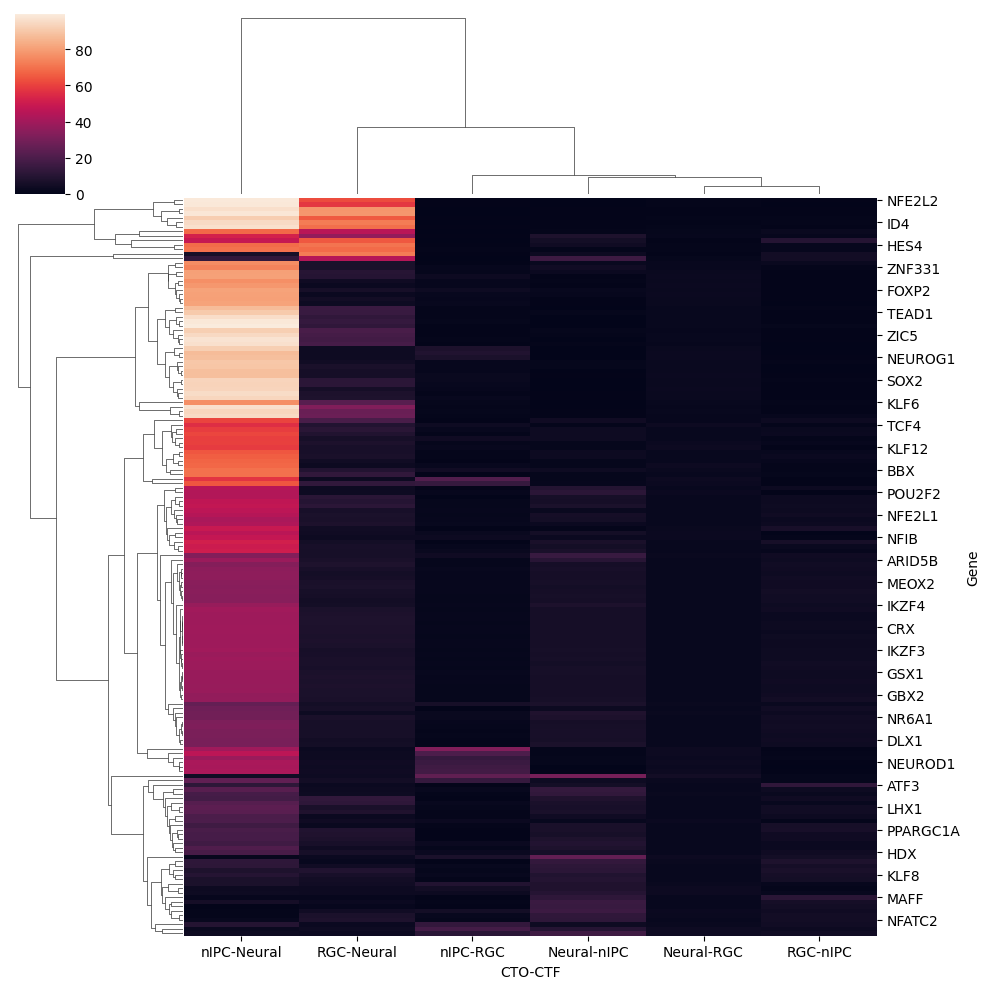

In [68]:
sns.clustermap(pivoted)

# Perturbation Score Sums (PSSs)

In [7]:
pss_folders = {k: f+'perturbations/perturbation_hdf5/' for k, f in dirlist.items()}
pss_folders

{'Gliogenesis': '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/perturbations/perturbation_hdf5/',
 'NeuralPCW16': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW16/perturbations/perturbation_hdf5/',
 'NeuralPCW20': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW20/perturbations/perturbation_hdf5/',
 'NeuralPCW21': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW21/perturbations/perturbation_hdf5/',
 'NeuralPCW24': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW24/perturbations/perturbation_hdf5/',
 'RGCmaturation': '/users/genomics/xoel/codebases/co_new/data/RGCmaturation/perturbations/perturbation_hdf5/'}

In [8]:
for k, v in pss_folders.items():
    
    for s in os.listdir(v):
        if '.csv' in s:
            pss = pd.read_csv(v+s, index_col=0)
            
            raise
            
# psss = pd.concat([pd.concat([ ], ignore_index=True).assign(sample=k)  ], ignore_index=True)

RuntimeError: No active exception to reraise

In [10]:
s

'KO.NegPSsum.MEF2C_0.0.csv'

In [26]:
psss = pd.concat([pd.concat([pd.read_csv(v+s, index_col=0) for s in os.listdir(v) if '.csv' in s], ignore_index=True).assign(sample=k) for k, v in pss_folders.items() ], ignore_index=True)

In [27]:
psss

,group,score,gene,sample
0,vRG,0.009213,MEF2C,Gliogenesis
1,vtRG,0.009381,MEF2C,Gliogenesis
2,oRG,0.158319,MEF2C,Gliogenesis
3,RG E,0.004935,MEF2C,Gliogenesis
4,RG L,0.009213,MEF2C,Gliogenesis
...,...,...,...,...
29872,not_vRG E,0.026963,NEUROG1,RGCmaturation
29873,not_vRG L,0.062637,NEUROG1,RGCmaturation
29874,not_tRG,0.063820,NEUROG1,RGCmaturation
29875,not_oRG E,0.041010,NEUROG1,RGCmaturation


In [28]:
psss.to_csv(resultsdir+'PSSs.txt', index=False, header=True, sep='\t')

In [29]:
# psss_wide = psss.pivot(index='gene', columns=['sample', 'group'], values='log1p')
# psss_wide.to_excel(resultsdir+'PSSs.xlsx', index=False, header=True)

In [30]:
psss.group = pd.Categorical(psss.group, psss.group.unique())

# Export RNA datasets

In [31]:
import scanpy as sc

In [32]:
rnadir = resultsdir+'rna_files/'
os.makedirs(rnadir, exist_ok=True)

In [33]:
# rna_key = 'RNA.processed.3000_GENES'
rna_key = 'RNA.processed'

rna_files = {k: f+rna_key+'.h5ad' for k,f in dirlist.items()}
rna_files

{'Gliogenesis': '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/RNA.processed.h5ad',
 'NeuralPCW16': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW16/RNA.processed.h5ad',
 'NeuralPCW20': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW20/RNA.processed.h5ad',
 'NeuralPCW21': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW21/RNA.processed.h5ad',
 'NeuralPCW24': '/users/genomics/xoel/codebases/co_new/data/NeuralPCW24/RNA.processed.h5ad',
 'RGCmaturation': '/users/genomics/xoel/codebases/co_new/data/RGCmaturation/RNA.processed.h5ad'}

In [56]:
# SYNCHRONOUS ONLY MAPS
for cl, rna_file in rna_files.items():
        
    adata = sc.read_h5ad(rna_file, backed=True)
    
    maps = {}
    
    for map_key, map_vals in adata.obsm.items():
        if map_key in ['X_draw_graph_fa','X_phate', 'X_umap_original']:
            maps[map_key] = pd.DataFrame(map_vals, index=adata.obs_names)
            
            if (('RGC' in cl) | ('Gliog' in cl)) & (map_key == 'X_draw_graph_fa'):
                maps['Used_map'] = maps[map_key].copy()
                maps['Used_map'].columns = [f'Used_map_{c}' for c in maps['Used_map'].columns]
            elif ('Neural' in cl) & (map_key == 'X_phate'):
                maps['Used_map'] = maps[map_key].copy()
                maps['Used_map'].columns = [f'Used_map_{c}' for c in maps['Used_map'].columns]
                
            maps[map_key].columns = [f'{map_key}_{c}' for c in maps[map_key].columns]
    
    maps = {k: maps[k] for k in ['Used_map', 'X_umap_original', 'X_draw_graph_fa','X_phate'] if k in maps.keys()}
    maps = pd.concat(maps.values(), axis=1)

    maps.to_csv(f'{rnadir}{cl}.maps.csv', index=True, header=True)


In [57]:
maps

,Used_map_0,Used_map_1,X_umap_original_0,X_umap_original_1,X_draw_graph_fa_0,X_draw_graph_fa_1,X_phate_0,X_phate_1
hft_w20_p3_r1_AAACCCAGTACTCGCG,-9045.158389,4993.308970,-7.379426,-12.918773,-9045.158389,4993.308970,0.011056,0.004546
hft_w20_p3_r1_AAAGAACGTGCATTTG,-13354.638517,25409.755815,-6.866389,-6.607686,-13354.638517,25409.755815,0.036862,0.002559
hft_w20_p3_r1_AAAGGATCAAATGGAT,-4441.308613,419.563015,-7.629405,-11.246958,-4441.308613,419.563015,0.001564,-0.005730
hft_w20_p3_r1_AAAGTCCCAAATTGGA,-21277.224610,33901.391259,-6.857548,-14.885457,-21277.224610,33901.391259,0.039970,0.036223
hft_w20_p3_r1_AAAGTGACATCATGAC,4459.056845,-3377.098965,-8.144914,-10.326964,4459.056845,-3377.098965,-0.004555,-0.011163
...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTCAGTTCCCGTGAG,12871.958012,-25254.514025,-9.893041,-8.273386,12871.958012,-25254.514025,-0.023111,0.021135
hft_w16_p7_r2_TTTCCTCTCATTACTC,17155.111685,-19035.446047,-8.301000,-7.170821,17155.111685,-19035.446047,-0.029628,0.009806
hft_w16_p7_r2_TTTGATCCAGCGGATA,-2615.694432,14880.513793,-7.216786,-9.737917,-2615.694432,14880.513793,0.012315,-0.008179
hft_w16_p7_r2_TTTGGTTTCCCTTTGG,9578.262746,15741.022963,-8.138324,-4.408466,9578.262746,15741.022963,0.004794,-0.016858


In [45]:
# # SYNCHRONOUS
# for cl, rna_file in rna_files.items():
        
#     adata = sc.read_h5ad(rna_file)
#     for map_key in ['draw_graph_fa', 'phate']:
#         adata.obs[['X_'+map_key, 'Y_'+map_key]] = adata.obsm['X_'+map_key]
    
#     adata.to_df().to_csv(f'{rnadir}{cl}.{rna_key}.csv', index=True, header=True)
#     pd.DataFrame(adata.layers['raw_count'],
#                  index=adata.obs_names, 
#                  columns=adata.var_names).to_csv(f'{rnadir}{cl}.raw_counts.{rna_key}.csv', index=True, header=True)
#     adata.obs.to_csv(f'{rnadir}{cl}.metadata.{rna_key}.csv', index=True, header=True)
#     adata.var.to_csv(f'{rnadir}{cl}.gene_metadata.{rna_key}.csv', index=True, header=True)


In [46]:
# ASYNCHRONOUS
def _save_rna(cl_and_file):
    cl, rna_file = cl_and_file
    
    adata = sc.read_h5ad(rna_file)
    for map_key in ['draw_graph_fa', 'phate']:
        adata.obs[['X_'+map_key, 'Y_'+map_key]] = adata.obsm['X_'+map_key]
    
    adata.to_df().to_csv(f'{rnadir}{cl}.{rna_key}.csv', index=True, header=True)
    pd.DataFrame(adata.layers['raw_count'],
                 index=adata.obs_names, 
                 columns=adata.var_names).to_csv(f'{rnadir}{cl}.raw_counts.RNA.csv',
                                                 index=True, 
                                                 header=True)
    adata.obs.to_csv(f'{rnadir}{cl}.metadata.{rna_key}.csv',
                     index=True,
                     header=True)
    adata.var.to_csv(f'{rnadir}{cl}.gene_metadata.{rna_key}.csv',
                     index=True, 
                     header=True)
    
    return()

In [47]:
process_map(_save_rna, list(rna_files.items()))

  0%|          | 0/3 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/users/genomics/xoel/codebases/co_new/data/Gliogenesis/RNA.processed.3000_GENES.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Same for raw dataset
adata = sc.read_h5ad('/users/genomics/xoel/codebases/celloracle/data2/rna.raw.h5ad')

adata.to_df().to_csv(f'{rnadir}All.RNA.RAW.csv', index=True, header=True)

adata.obs.to_csv(f'{rnadir}All.metadata.RNA.RAW.csv',
                 index=True,
                 header=True)
adata.var.to_csv(f'{rnadir}All.gene_metadata.RNA.RAW.csv',
                 index=True, 
                 header=True)


# Export ATAC datasets

In [ ]:
atacdir = resultsdir+'atac_files/'
os.makedirs(atacdir, exist_ok=True)

In [ ]:
import pandas as pd

In [ ]:
acts = pd.read_csv('~/codebases/celloracle/OLD/data/Pasca/GSE162170_atac_gene_activities.tsv', 
                   sep=' ')
acts

In [37]:
sample_meta = pd.read_csv('~/codebases/celloracle/OLD/data/Pasca/GSE162170_atac_sample_qc.tsv', sep='\t')
sample_meta

,replicate_id,sample_id,batch_id,time,median_tss_enrichment,cr_n_fragments,cr_n_fragments_usable,cr_n_cells,cr_median_fragments_per_cell,cr_frac_waste_total,cr_frac_waste_no_barcode,cr_frac_waste_non_cell_barcode,cr_frac_waste_mitochondrial,cr_frac_waste_unmapped,cr_frac_waste_lowmapq,cr_frac_waste_duplicate,cr_frac_tss,cr_frac_doublet_rate
0,hft_w16_p7_r1,hft_w16_p7,b2020_03,pcw16,24.4634,545881418,103662779,2376,37011.5,0.810100,0.022818,0.092013,0.001555,0.023430,0.069434,0.600014,0.359874,0.015132
1,hft_w16_p7_r2,hft_w16_p7,b2020_03,pcw16,24.7560,260959476,85560925,2531,28495.0,0.672129,0.023557,0.100500,0.001622,0.022837,0.069116,0.453748,0.352731,0.030363
2,hft_w16_p7_r3,hft_w16_p7,b2020_03,pcw16,22.9020,180604678,73822694,2866,21832.0,0.591247,0.022941,0.092844,0.001670,0.023569,0.069765,0.379713,0.347598,0.019868
3,hft_w20_p3_r1,hft_w20_p3,b2019_06,pcw20,25.5499,324986356,106247885,2823,35874.0,0.673070,0.018137,0.057186,0.002063,0.020645,0.054401,0.519156,0.403504,0.014878
4,hft_w20_p3_r2,hft_w20_p3,b2019_06,pcw20,24.2941,53814870,32711880,2416,12830.5,0.392140,0.015847,0.053333,0.002145,0.020048,0.055790,0.243455,0.408275,0.008278
5,hft_w21_p5_r1,hft_w21_p5,b2020_02,pcw21,16.1152,389169402,49922125,3303,9014.0,0.871721,0.025340,0.259724,0.002566,0.006618,0.033700,0.541115,0.409645,0.011765
6,hft_w21_p5_r2,hft_w21_p5,b2020_02,pcw21,13.6471,236425071,47798845,3755,7152.0,0.797827,0.024019,0.209907,0.003133,0.006306,0.034950,0.516824,0.411051,0.010378
7,hft_w21_p5_r3,hft_w21_p5,b2020_02,pcw21,14.5098,255653171,48704386,3771,7829.0,0.809490,0.023874,0.244962,0.002965,0.006235,0.034076,0.495127,0.415942,0.015844
8,hft_w21_p5_r4,hft_w21_p5,b2020_02,pcw21,13.5686,377096814,54824447,4195,7381.0,0.854614,0.023660,0.177353,0.003352,0.007362,0.036983,0.603527,0.412681,0.008812
9,hft_w24_p6_r1,hft_w24_p6,b2020_02,pcw24,9.8431,330102146,49237060,3185,4328.0,0.850843,0.024184,0.158396,0.003568,0.008944,0.041413,0.611221,0.378029,0.017231


In [38]:
cell_meta = pd.read_csv('~/codebases/celloracle/OLD/data/Pasca/GSE162170_atac_cell_metadata.txt', sep='\t')
cell_meta

,Cell.ID,Sample.ID,Age,Tissue.ID,Sample.Type,Batch,Iterative.LSI.Clusters,Tss.Enrichment,.CR.cellQC.barcode,.CR.cellQC.total,...,.CR.cellQC.TSS_fragments,.CR.cellQC.DNase_sensitive_region_fragments,.CR.cellQC.enhancer_region_fragments,.CR.cellQC.promoter_region_fragments,.CR.cellQC.on_target_fragments,.CR.cellQC.blacklist_region_fragments,.CR.cellQC.peak_region_fragments,.CR.cellQC.peak_region_cutsites,Cell.Barcode,TSS.Enrichment.Unsmoothed
0,hft_w20_p3_r1_cell_0,hft_w20_p3_r1,pcw20,HFT3,HFT,b2019_06,c7,21.529711,AAACGAAAGAGCGAAA-1,106900,...,16504,28031,7037,16111,31479,0,32017,62530,AAACGAAAGAGCGAAA-1,29.923664
1,hft_w20_p3_r1_cell_1,hft_w20_p3_r1,pcw20,HFT3,HFT,b2019_06,c4,23.737453,AAACGAAAGCAGGACT-1,120734,...,20884,29856,6088,20757,33613,1,33311,65168,AAACGAAAGCAGGACT-1,32.360743
2,hft_w20_p3_r1_cell_2,hft_w20_p3_r1,pcw20,HFT3,HFT,b2019_06,c13,28.220040,AAACGAAAGGATCCTT-1,112894,...,18150,33549,9120,17505,36640,0,37145,73104,AAACGAAAGGATCCTT-1,37.601297
3,hft_w20_p3_r1_cell_3,hft_w20_p3_r1,pcw20,HFT3,HFT,b2019_06,c7,21.165212,AAACGAAAGGCTTCGC-1,94462,...,15648,26772,6789,15255,29934,2,30571,59831,AAACGAAAGGCTTCGC-1,29.984051
4,hft_w20_p3_r1_cell_4,hft_w20_p3_r1,pcw20,HFT3,HFT,b2019_06,c1,30.964802,AAACGAACAAAGCTGG-1,75329,...,10516,21822,7305,10044,24259,0,24423,47890,AAACGAACAAAGCTGG-1,48.929664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31299,hft_w16_p7_r3_cell_2860,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,57305,...,9074,16800,6121,8305,19882,0,16689,32055,TTTGGTTGTGTCGTCG-1,36.056338
31300,hft_w16_p7_r3_cell_2862,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,15.333333,TTTGTGTAGGTTGTGG-1,17233,...,3932,7066,2405,3695,8248,0,7043,13521,TTTGTGTAGGTTGTGG-1,32.000000
31301,hft_w16_p7_r3_cell_2863,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,22.873213,TTTGTGTGTACTTCGA-1,38741,...,6969,13430,4889,6595,15480,0,13573,26139,TTTGTGTGTACTTCGA-1,46.215139
31302,hft_w16_p7_r3_cell_2864,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,18.983297,TTTGTGTGTTCGGGAA-1,77301,...,12717,23092,7675,12205,26776,2,23297,44898,TTTGTGTGTTCGGGAA-1,28.888889


In [39]:
sample_meta.to_csv(atacdir+'ATAC_sample_metadata.tsv', index=True, header=True, sep='\t')

In [40]:
cell_meta.to_csv(atacdir+'ATAC_cell_metadata.tsv', index=True, header=True, sep='\t')

In [41]:
acts.to_csv(atacdir+'ATAC_gene_activity.tsv', index=True, header=True, sep='\t')

# Gene presence

In [18]:
import pandas as pd
import numpy as np

## Files

In [19]:
from tqdm.auto import tqdm

In [20]:
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm.contrib.concurrent import process_map  # or thread_map

In [21]:
paths = pd.DataFrame({'path': {
    'RNA dataset': 'RNA.unprocessed.h5ad',
    'RNA HV': 'RNA.processed.h5ad',
    'ATAC GRN': 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
    'CT GRN dir': 'cluster_GRN/',
    'Perturbation dir': 'perturbations/perturbation_transitions/'
}})

paths['type'] = paths['path'].apply(lambda x:
                                    'folder' if x[-1] == '/' else x.split('.')[-1])

paths

,path,type
ATAC GRN,base_grn.coaccessibility=0.8.score=8.base_grn....,parquet
CT GRN dir,cluster_GRN/,folder
Perturbation dir,perturbations/perturbation_transitions/,folder
RNA HV,RNA.processed.h5ad,h5ad
RNA dataset,RNA.unprocessed.h5ad,h5ad


In [22]:
def search_genes_in_pertdir(x, genetable):
    
    pert_genes = list({y.split('_')[0].split('.')[1] for y in os.listdir(x['path'])})
        
    genetable['Perturbed'] = genetable.index.isin(pert_genes)
    
    
    return(genetable)

def search_genes_in_ct_grns(x, genetable):
    
    grn_csvs = {k.split('.')[0]: x['path']+k for k in [p for p in os.listdir(x['path']) if 
                                                                     'raw_GRN' not in p and
                                                                     '.ipynb' not in p]}
    # print(grn_csvs)
    grn_csvs = {k: pd.read_csv(f, index_col=0) for k,f in grn_csvs.items()}  
    # print(grn_csvs)
    grn_genes = {f'{k} GRN {t}': v.unique().tolist() for k,df in grn_csvs.items() for t,v in df[['source', 'target']].items()}
    # print(grn_genes)
    for col, gs in grn_genes.items():
        genetable[col] = genetable.index.isin(gs)
    
    return(genetable)

def search_genes_in_parquet(x, genetable):
    data = pd.read_parquet(x['path'])
    tfs = data.columns[2:].unique().tolist()
    targets = data['gene_short_name'].unique().tolist()
    
    genetable[x.name + ' SOURCE'] = genetable.index.isin(tfs)
    genetable[x.name + ' TARGET'] = genetable.index.isin(targets)
    
    
    return(genetable)

def search_genes_in_h5ad(x, genetable):
    
    data = sc.read_h5ad(x['path'], backed=True)
    gset = data.var.index.unique().tolist()
    
    genetable[x.name] = genetable.index.isin(gset)
    
    
    return(genetable)

def search_genes(x, genelists):
    
    
    genes = pd.Series(list({g for _,gs in glists.items() for g in gs}))
    genetable = pd.DataFrame({k: genes.isin(gs) for k, gs in glists.items()})
    genetable.index = genes.tolist()
    
    
    
    
    if x['type'] == 'parquet':
        # print('Doing parquet')
        genetable = search_genes_in_parquet(x, genetable=genetable)
        # print('Done')
        
    if x['type'] == 'h5ad':
        # print('Doing h5ad')
        genetable = search_genes_in_h5ad(x, genetable=genetable)
        # print('Done')
        
    if 'cluster_GRN/' in x['path']:
        # print('Doing cluster GRN')
        genetable = search_genes_in_ct_grns(x, genetable=genetable)    
        # print('Done')
        
    if 'perturbations/' in x['path']:
        # print('Doing perturbations')
        genetable = search_genes_in_pertdir(x, genetable=genetable)    
        # print('Done')

        
    return(genetable)

def search_path_prefix(prefix, paths, genelists):
    
    paths['path'] = prefix+paths['path']

    genetable = None
    dfs = list()
    for i in tqdm(range(paths.shape[0])):
        # print(f'Processing {paths.iloc[i,0]}')
        df = search_genes(x=paths.iloc[i,:], genelists=genelists)
        if genetable is None:
            genetable = df[list(genelists.keys())]
        dfs.append(df.drop(list(genelists.keys()), axis=1))

    genetable = pd.merge(
        genetable,
        pd.concat(dfs, axis=1, ignore_index=False),
        left_index=True, right_index=True)    
    
    return(genetable)

def _search_path_prefix(prefix):
    return(search_path_prefix(prefix=prefix, paths=paths.copy(), genelists=glists))


In [23]:
# presence_dfs = {k: search_path_prefix(prefix=v, paths=paths.copy(), genelists=glists) for k, v in dirlist.items()}
# presence_dfs

In [24]:
ks,vs = tuple(zip(*dirlist.items()))

In [25]:
# presence_dfs = {}
# for k, v in dirlist.items():
#     print(k)
#     presence_dfs[k] = search_path_prefix(prefix=v, paths=paths.copy(), genelists=glists)
    

presence_dfs = dict(list(zip(ks, 
                             process_map(_search_path_prefix, vs, max_workers=len(vs)))))

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
[df.index.str.strip().is_unique for k, df in presence_dfs.items()]

[True, True, True, True, True, True]

In [27]:
presencedir =  resultsdir+'GenePresence/'
os.makedirs(presencedir, exist_ok=True)

In [28]:
with pd.ExcelWriter(presencedir+'GenePresence.xlsx') as writer:
    for sample, sdf in presence_dfs.items():
        print(f'Writing excel sheet: {sample}')
        sdf.to_excel(writer, sheet_name=sample, index=True, header=True)
        sdf.to_csv(presencedir+sample+'.xlsx', index=True, header=True)
        

Writing excel sheet: Gliogenesis
Writing excel sheet: NeuralPCW16
Writing excel sheet: NeuralPCW20
Writing excel sheet: NeuralPCW21
Writing excel sheet: NeuralPCW24
Writing excel sheet: RGCmaturation


### Long format

In [29]:
pres_long = []
for sample, df in presence_dfs.items():
    df = df.reset_index().melt(id_vars=['index']+list(glists.keys())).rename({'index':'Gene'}, axis=1)
    df['Sample'] = sample
    pres_long.append(df)
pres_long = pd.concat(pres_long, axis=0)

In [30]:
steps = {
    'ATAC GRN SOURCE':1, 
    'ATAC GRN TARGET':2, 

    'RNA dataset':3,
    'RNA HV':4,
    
    'Perturbed':6}

pres_long['step'] = pres_long.variable.replace(steps)
pres_long.loc[pres_long.variable.apply(lambda x: 'GRN' in x and 'ATAC' not in x), 'step'] = 5    


In [31]:
pres_long['Cell type'] = np.where(
    pres_long.step == 5,
    pres_long.variable.apply(lambda x: x.split(' GRN')[0]),
    np.nan)

In [32]:
pres_long.variable.unique()

array(['ATAC GRN SOURCE', 'ATAC GRN TARGET', 'vRG L GRN source',
       'vRG L GRN target', 'tRG GRN source', 'tRG GRN target',
       'oRG L GRN source', 'oRG L GRN target', 'mGPC GRN source',
       'mGPC GRN target', 'Astro GRN source', 'Astro GRN target',
       'vRG E GRN source', 'vRG E GRN target', 'oRG E GRN source',
       'oRG E GRN target', 'OPC GRN source', 'OPC GRN target',
       'Perturbed', 'RNA HV', 'RNA dataset', 'GluN7 GRN source',
       'GluN7 GRN target', 'GluN2 GRN source', 'GluN2 GRN target',
       'GluN3 GRN source', 'GluN3 GRN target', 'nIPC GRN source',
       'nIPC GRN target', 'GluN1 GRN source', 'GluN1 GRN target',
       'Neu E GRN source', 'Neu E GRN target', 'GluN5 GRN source',
       'GluN5 GRN target', 'GluN4 GRN source', 'GluN4 GRN target',
       'GluN6 GRN source', 'GluN6 GRN target', 'GluN8 GRN source',
       'GluN8 GRN target'], dtype=object)

In [33]:
pres_long.to_excel(presencedir+'GenePresenceLong.xlsx', sheet_name='GenePresence', index=False, header=True)
pres_long.to_csv(presencedir+'GenePresenceLong.csv', index=False, header=True)

In [44]:
pres_long[(pres_long['Gene']=='FOXG1') & (pres_long['variable'].str.startswith('RNA'))]

,Gene,Diseases,TFs,Disease regulon,Disease core,Disease target,ASD core,BD_2019 core,DD core,FCDandmTOR core,...,P8.FGF10 target,P8.FGF20 target,Regulon gene,Regulon core,Regulon target,variable,value,Sample,step,Cell type
116960,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA HV,False,Gliogenesis,4,NaN
122915,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA dataset,True,Gliogenesis,3,NaN
140780,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA HV,False,NeuralPCW16,4,NaN
146735,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA dataset,True,NeuralPCW16,3,NaN
116960,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA HV,False,NeuralPCW20,4,NaN
122915,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA dataset,True,NeuralPCW20,3,NaN
116960,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA HV,False,NeuralPCW21,4,NaN
122915,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA dataset,True,NeuralPCW21,3,NaN
128870,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA HV,False,NeuralPCW24,4,NaN
134825,FOXG1,True,True,True,True,True,False,False,False,False,...,False,False,True,True,True,RNA dataset,True,NeuralPCW24,3,NaN
